基本原理和离散动作是一样的,连续动作的概率使用高斯密度函数计算即可.

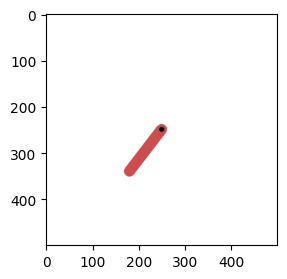

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch


#定义模型
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
        )
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )
        self.sigma = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state):
        state = self.s(state)

        return self.mu(state), self.sigma(state).exp()


model_action = Model()

model_value = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_action(torch.randn(2, 3)), model_value(torch.randn(2, 3))

((tensor([[0.0291],
          [0.0673]], grad_fn=<TanhBackward0>),
  tensor([[0.8901],
          [0.8493]], grad_fn=<ExpBackward0>)),
 tensor([[ 0.0453],
         [-0.1344]], grad_fn=<AddmmBackward0>))

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        mu, sigma = model_action(torch.FloatTensor(s).reshape(1, 3))
        a = random.normalvariate(mu=mu.item(), sigma=sigma.item())

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 3)
    action = torch.FloatTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)
    next_state = torch.FloatTensor(next_state).reshape(-1, 3)
    over = torch.LongTensor(over).reshape(-1, 1)

    return state, action, reward, next_state, over, reward.sum().item()


state, action, reward, next_state, over, reward_sum = play()

reward_sum

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\User\AppData\Local\Temp\ipykernel_44956\3994207745.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor(state).reshape(-1, 3)


30.417152404785156

In [4]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=5e-3)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)

In [5]:
def train_value(state, reward, next_state, over):
    requires_grad(model_action, False)
    requires_grad(model_value, True)

    #计算target
    with torch.no_grad():
        target = model_value(next_state)
    target = target * 0.98 * (1 - over) + reward

    #每批数据反复训练10次
    for _ in range(10):
        #计算value
        value = model_value(state)

        loss = torch.nn.functional.mse_loss(value, target)
        loss.backward()
        optimizer_value.step()
        optimizer_value.zero_grad()

    #减去value相当于去基线
    return (target - value).detach()


value = train_value(state, reward, next_state, over)

value.shape

torch.Size([200, 1])

In [6]:
def train_action(state, action, value):
    requires_grad(model_action, True)
    requires_grad(model_value, False)

    #计算优势函数
    delta = []
    for i in range(len(value)):
        s = 0
        for j in range(i, len(value)):
            s += value[j] * (0.9 * 0.9)**(j - i)
        delta.append(s)
    delta = torch.FloatTensor(delta).reshape(-1, 1)

    #更新前的动作概率
    with torch.no_grad():
        mu, sigma = model_action(state)
        prob_old = torch.distributions.Normal(mu, sigma).log_prob(action).exp()

    #每批数据反复训练10次
    for _ in range(10):
        #更新后的动作概率
        mu, sigma = model_action(state)
        prob_new = torch.distributions.Normal(mu, sigma).log_prob(action).exp()

        #求出概率的变化
        ratio = prob_new / prob_old

        #计算截断的和不截断的两份loss,取其中小的
        surr1 = ratio * delta
        surr2 = ratio.clamp(0.8, 1.2) * delta

        loss = -torch.min(surr1, surr2).mean()

        #更新参数
        loss.backward()
        optimizer_action.step()
        optimizer_action.zero_grad()

    return loss.item()


train_action(state, action, value)

0.01315974723547697

In [ ]:
def train():
    model_action.train()
    model_value.train()

    #训练N局
    for epoch in range(1000):
        #一个epoch最少玩N步
        steps = 0
        while steps < 200:
            state, action, reward, next_state, over, _ = play()
            steps += len(state)

            #训练两个模型
            delta = train_value(state, reward, next_state, over)
            loss = train_action(state, action, delta)

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()